In [1]:
from __future__ import print_function, division
import argparse
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import os, shutil
import math
import fnmatch
from collections import OrderedDict
import cv2

import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn import metrics
import time
import copy
import seaborn as sns
from pytorch_model_summary import summary
from torch.nn.utils import weight_norm
from matplotlib import pyplot as plt

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

PyTorch Version:  1.10.0
Torchvision Version:  0.11.1
cuda:0
NVIDIA GeForce RTX 3080 Ti


In [2]:
class CAE_classify(nn.Module):
    def __init__(self, input_shape=[400,400,1], latent_channels=1024, num_clusters=2, filters=[32, 64, 128, 256], dropout=0.1):
        super(CAE_classify, self).__init__()
        self.pretrained = False
        self.latent_channels = latent_channels
        self.input_shape = input_shape
        self.filters = filters
        self.num_clusters = num_clusters
        
        self.encoder2d = nn.Sequential(OrderedDict([
            ('conv2d1_1', nn.Conv2d(input_shape[2], filters[0], 5, stride=2, padding=2, bias=False)),
          ('relu2d1_1', nn.ReLU()),
          ('bn2d1_1', nn.BatchNorm2d(filters[0])),
            ('conv2d2_1', nn.Conv2d(filters[0], filters[1], 5, stride=2, padding=2, bias=False)),
          ('relu2d2_1', nn.ReLU()),
          ('bn2d2_1', nn.BatchNorm2d(filters[1])),
            ('conv2d3_1', nn.Conv2d(filters[1], filters[2], 5, stride=2, padding=2, bias=False)),
          ('relu2d3_1', nn.ReLU()),
        ]))
        lin_features_len = ((input_shape[0] // 2 // 2 ) // 2) * ((input_shape[1] // 2 // 2 ) // 2) * filters[2]
        self.embedding2d = nn.Linear(lin_features_len, latent_channels, bias=False)
        self.fc1 = nn.Linear(latent_channels, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, num_clusters)
        self.relu = nn.ReLU()

    def forward(self, x):
        # tansmission
        x = self.encoder2d(x)
        x = x.view(x.size(0), -1)
        x = self.embedding2d(x)
        x_out = x
        
        x = x
        x = self.relu(x)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        
        pred = nn.functional.log_softmax(x,dim=1)
        
        return pred

In [3]:
print(summary(CAE_classify(latent_channels=1024),torch.zeros((1,1,400,400)), show_input=False))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 32, 200, 200]             800             800
            ReLU-2     [1, 32, 200, 200]               0               0
     BatchNorm2d-3     [1, 32, 200, 200]              64              64
          Conv2d-4     [1, 64, 100, 100]          51,200          51,200
            ReLU-5     [1, 64, 100, 100]               0               0
     BatchNorm2d-6     [1, 64, 100, 100]             128             128
          Conv2d-7      [1, 128, 50, 50]         204,800         204,800
            ReLU-8      [1, 128, 50, 50]               0               0
          Linear-9             [1, 1024]     327,680,000     327,680,000
           ReLU-10             [1, 1024]               0               0
         Linear-11              [1, 512]         524,800         524,800
    BatchNorm1d-12              [1, 512]          

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
#     print(output.size())
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def save_checkpoint(state, is_best_loss, filename='checkpoint.pth.tar', dirname='.'):
    fpath = os.path.join(dirname, filename + '_latest.pth.tar')
    torch.save(state, fpath)
    if is_best_loss:
        bpath = os.path.join(dirname, filename + '_best_acc.pth.tar')
        shutil.copyfile(fpath, bpath)
        
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          my_dpi=100,
                          title=None,
                          saved=True,
                          save_name='Unsupervised Learning.png'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize, dpi=my_dpi)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    if saved:
        plt.savefig(save_name, dpi=my_dpi*10, bbox_inches='tight')

In [5]:
def training(model, dataloaders, criterion, optimizers, schedulers, params):
    # Note the time
    since = time.time()

    best_val_acc = 0
    losses_tr = []
    losses_val = []
    learning_rate = []
    accs_tr = []
    accs_val = []

    # Unpack parameters
    pretrained = params['model_files']
    print_freq = params['print_freq']
    dataset_size = params['dataset_size']
    device = params['device']
    batch = params['batch']
    num_epochs = params['epochs']
    fused = params['fused']

    # Prep variables for weights and accuracy of the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # optionally resume from a checkpoint
    if params['resume']:
        if os.path.isfile(params['resume']):
            print("=> loading checkpoint '{}'".format(params['resume']))
            checkpoint = torch.load(params['resume'])
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']

            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(params['resume']))
            
    ckpt_dir = params['ckpt_dir']
    
    optimizer1, optimizer2 = optimizers
    scheduler1, scheduler2 = schedulers
    dataloader_train, dataloader_val = dataloaders
    
    # Go through all epochs
    print('\nPretraining')
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('\n\nEpoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        if epoch < 5:
            for param_group in optimizer1.param_groups:
                print("\nLR:", param_group['lr'], '\n---------------------')
                lr = param_group['lr']
        else:
            for param_group in optimizer2.param_groups:
                print("\nLR:", param_group['lr'], '\n---------------------')
                lr = param_group['lr']
        if fused:
            loss_tr, acc_tr = train_fused(dataloader_train, model, criterion, optimizers, params, epoch)
            loss_val, acc_val = validate_fused(dataloader_val, model, criterion, params, epoch)
        else:
            loss_tr, acc_tr = train_fused(dataloader_train, model, criterion, optimizers, params, epoch)
            loss_val, acc_val = validate_fused(dataloader_val, model, criterion, params, epoch)
#             raise('Not Implemented!')
        
        # learning scheduler
        if epoch < 5:
            scheduler1.step(loss_val)
        elif epoch > num_epochs * (1/3):
            scheduler2.step(loss_val)
            
        # append values
        losses_tr.append(loss_tr)
        losses_val.append(loss_val)
        accs_tr.append(acc_tr)
        accs_val.append(acc_val)
        learning_rate.append(lr)
        
        is_best_acc = acc_val > best_val_acc
        if is_best_acc:
            best_val_acc = max(acc_val, best_val_acc)
            print('Best val acc reached at epoch: {:.0f}\t Accuracy: {:.3f}'.format(epoch+1, best_val_acc))
            best_model_wts = copy.deepcopy(model.state_dict())
        
            
        dict_checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_model_wts': best_model_wts,
            'losses_tr': losses_tr,
            'losses_val': losses_val,
            'accuracy_train': accs_tr,
            'accuracy_val': accs_val,
            'learning_rate' : learning_rate,
        }
        
        save_checkpoint(dict_checkpoint, is_best_acc, 'Classify_Trained_'+str(params['boundary']), dirname=ckpt_dir)
        epoch_time = time.time()-epoch_start
        print('\nEpoch {} Training Time: {:.0f}m {:.0f}s Accuracy: {:.02f}% Best Accuracy {:.02f}%'.format(epoch+1, epoch_time // 60, epoch_time % 60, acc_val, best_val_acc))
    time_elapsed = time.time() - since
    print('Pretraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    model.pretrained = True
    torch.save(model.state_dict(), pretrained)

    return model

def train_fused(dataloader, model, criterion, optimizers, params, epoch):
    # Note the time
    since = time.time()
    
    losses = AverageMeter()
    top1 = AverageMeter()
    epoch_samples = 0
    
    device = params['device']
    print_freq = params['print_freq']
    optimizer1, optimizer2 = optimizers
    
    model.train()
    print('\nTraining:')
    for i, (inputs, labels) in enumerate(dataloader):
        batch_size = inputs.shape[0]
        inputs = inputs.to(device)
        labels = labels.to(device)
        epoch_samples += batch_size
        
        # compute outputs
        outputs = model(inputs)
#         preds = torch.argmax(outputs, dim=1)
#         print(preds)
#         print(labels)
        loss = criterion(outputs, labels)
        
        acc = accuracy(outputs, labels)[0]
        top1.update(acc.item(), batch_size)
        losses.update(loss.item(), batch_size)
        
        # compute gradient and do SGD step
        if epoch < 5:
            optimizer1.zero_grad()
        else:
            optimizer2.zero_grad()
        
        loss.backward()
        
        if epoch < 5:
            optimizer1.step()
        else:
            optimizer2.step()
            
        if (i) % print_freq == 0:
            print('Train: Epoch: [{0}][{1}/{2}]\t'
                  'Accuracy {acc.val:.4f} ({acc.avg:.4f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch+1, i+1, len(dataloader), acc=top1, loss=losses))
    print('Accuracy {acc.avg:.4f}, \t Loss {loss.avg:.4f}, \t Time: {time}'.format(acc=top1, loss=losses, time=time.time()-since))
    return losses.avg, top1.avg

def validate_fused(dataloader, model, criterion, params, epoch, mode='valid'):
    # Note the time
    since = time.time()
    
    losses = AverageMeter()
    top1 = AverageMeter()
    epoch_samples = 0
    
    device = params['device']
    print_freq = params['print_freq']
    model.eval()
    
    print('\n')
    print(mode,':')
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            batch_size = inputs.shape[0]
            inputs = inputs.to(device)
            labels = labels.to(device)
            epoch_samples += batch_size

            # compute outputs
            outputs = model(inputs)
#             preds = torch.argmax(outputs, dim=1)

            loss = criterion(outputs, labels)

            acc = accuracy(outputs, labels)[0]
            top1.update(acc.item(), batch_size)
            losses.update(loss.item(), batch_size)


            if (i) % print_freq == 0:
                print('Validation: Epoch: [{0}][{1}/{2}]\t'
                      'Accuracy {acc.val:.4f} ({acc.avg:.4f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                       epoch+1, i+1, len(dataloader), acc=top1, loss=losses))
    
    
    print('Accuracy {acc.avg:.4f}, \t Loss {loss.avg:.4f}, \t Time: {time}'.format(acc=top1, loss=losses, time=time.time()-since))
    return losses.avg, top1.avg

In [6]:
from skimage import io
import skimage.transform
import scipy
import scipy.io as sio
from torch.utils.data.dataset import Dataset

class MyDataset_mat(Dataset):
    def __init__(self, tm_paths, labels, transforms_tm=None):
        self.paths_tm = tm_paths
        self.transforms_tm = transforms_tm
        self.labels = labels
        
    def __getitem__(self, index):
        data_tm = sio.loadmat(self.paths_tm[index])['data']
        data_tm = np.transpose(np.array(data_tm), (2,0,1))
        
        x_tm = torch.from_numpy(data_tm.astype(np.float32))
#         x_tm = x_tm.unsqueeze(dim = 0)
        
        label = torch.from_numpy(np.asarray(self.labels[index]))
        label = label.to(torch.int64)
        if self.transforms_tm:
            x_tm = self.transforms_tm(x_tm)
        return x_tm,label
    
    def __len__(self):
        return len(self.paths_tm)
    

In [7]:
# important parameters
fused = False # fused network for SSC and tm

rate_pretrain = 1e-3 # pretraining learning rate
rate_pretrain_init = 1e-5
epochs = 100 # training epoches
update_interval = 5000 # intercal to update the clustering for target distribution

num_clusters = 2 # Number of clusters
latent_channels = 1024 # Number of latent channels


net_architecture = 'CAE_classify'
# weight = 0.5 # Adam params clustering weight decay
weight_pretrain = 0.5 # Adam params pretraining weight decay
dataset = '3D-IFC'
# patience_step = 5 # clustering Scheduler patience steps for rate update
patience_step_pretrain = 5 # training Scheduler patience steps for rate update
print_freq = 100 # training stats printing frequency

# parameters in dictionary
params = {}
params['resume'] = ''
params['net_arch'] = net_architecture
params['fused'] = fused
# Epochs
params['epochs'] = epochs
# Printing frequency
params['print_freq'] = print_freq
# Update interval for target distribution:
params['update_interval'] = update_interval

params['ckpt_dir'] = ''

net_is_path = True

dirs = ['runs', 'reports', 'nets']
list(map(lambda x: os.makedirs(x, exist_ok=True), dirs))

# Net architecture
model_name = net_architecture
# Indexing (for automated reports saving) - allows to run many trainings and get all the reports collected

In [8]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# csv_path = './reports/PT_GroundTruthLabel&ClusterLabel.csv'
csv_path = './reports/PT_mask.csv'
csv_data = pd.read_csv(csv_path)

# sscpath = csv_data.name
tmpath = csv_data.maskname
cluster_label = csv_data.cluster

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    
transforms_tm = transforms.Resize([400, 400])



for runs, (train_index, test_index) in enumerate(skf.split(tmpath, cluster_label)):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    
    trainpath, testpath, train_label, test_label = [], [], [], []
    for i in train_index:
        trainpath.append(tmpath[i])
        train_label.append(cluster_label[i])
    for i in test_index:
        testpath.append(tmpath[i])
        test_label.append(cluster_label[i])
    print('\nTest_Index: ', test_index)

    train_datasets = MyDataset_mat(trainpath, train_label, transforms_tm=transforms_tm)
    val_datasets = MyDataset_mat(testpath, test_label, transforms_tm=transforms_tm)

    print('Training data size: ', len(train_datasets))
    print('Validation data size: ', len(val_datasets))

    idx = runs+1
#     reports_list = sorted(os.listdir('nets'), reverse=True)
#     if reports_list:
#         for file in reports_list:
#             # print(file)
#             if fnmatch.fnmatch(file, model_name + '*' + 'trained.pt'):
#                 idx = int(str(file)[-14:-11]) + 1
#                 break
#     try:
#         idx
#     except NameError:
#         idx = 1
    print(idx)
    # Base filename
    name = model_name + '_' + str(idx).zfill(3)
    params['boundary'] = str(idx).zfill(3)

    # Filenames for report and weights
    pretrained = name + '_trained.pt'
    params['model_files'] = pretrained
    # Arrange filenames for report, network weights, pretrained network weights
    name_trained = os.path.join('nets', pretrained)
    params['ckpt'] = os.path.join('nets', 'ckpt')
    print('Dataloader Initialization Start:')
    # Number of classes in the dataset
    num_classes = num_clusters

    # Batch size for training (change depending on how much memory you have)
    batch_size = 16
    params['batch'] = batch_size

    # dataloaders
    dataloader_train = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=0)
    dataloader_val = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=True, num_workers=0)
    dataloaders = [dataloader_train, dataloader_val]

    dataset_size = {'train': len(train_datasets), 'val': len(val_datasets)}
    params['dataset_size'] = dataset_size

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    params['device'] = device

    print('Dataloader Initialized!')
    
    ckpt_dir = params['ckpt'] + '_' + params['net_arch'] + '_' + params['boundary']
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    print(ckpt_dir)
    params['ckpt_dir'] = ckpt_dir

    # Evaluate the proper model
    img_size = [400,400,1]
    to_eval = model_name + "(img_size, latent_channels=latent_channels)"
    model = eval(to_eval)
    
    model = model.to(device)
    # Reconstruction loss
    criterion_1 = nn.CrossEntropyLoss().cuda()

    # optimizer_pretrain = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain, weight_decay=weight_pretrain)
    optimizer_ft1 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain_init,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
    optimizer_ft2 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=rate_pretrain,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
    exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=patience_step_pretrain, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)
    exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=patience_step_pretrain, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)       


    optimizers = [optimizer_ft1, optimizer_ft2]
    schedulers = [exp_lr_scheduler1, exp_lr_scheduler2]

    model = training(model, dataloaders, criterion_1, optimizers, schedulers, params)

    # Save final model
    torch.save(model.state_dict(), name_trained)

Fold- 0 : Initializing Datasets and Dataloaders...

Test_Index:  [   0    9   20 ... 9353 9356 9357]
Training data size:  7488
Validation data size:  1872
1
Dataloader Initialization Start:
Dataloader Initialized!
nets\ckpt_CAE_classify_001

Pretraining


Epoch 1/100
----------

LR: 1e-05 
---------------------

Training:
Train: Epoch: [1][1/468]	Accuracy 50.0000 (50.0000)	Loss 0.6995 (0.6995)	
Train: Epoch: [1][101/468]	Accuracy 93.7500 (92.5124)	Loss 0.0861 (0.1987)	
Train: Epoch: [1][201/468]	Accuracy 93.7500 (92.7239)	Loss 0.2823 (0.1981)	
Train: Epoch: [1][301/468]	Accuracy 93.7500 (93.2101)	Loss 0.1606 (0.1876)	
Train: Epoch: [1][401/468]	Accuracy 100.0000 (93.5474)	Loss 0.0500 (0.1842)	
Accuracy 93.7500, 	 Loss 0.1785, 	 Time: 29.34614658355713


valid :
Validation: Epoch: [1][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.0940 (0.0940)	
Validation: Epoch: [1][101/117]	Accuracy 100.0000 (95.2970)	Loss 0.0524 (0.1319)	
Accuracy 95.2991, 	 Loss 0.1318, 	 Time: 2.4704232215881348
Best va

Validation: Epoch: [10][101/117]	Accuracy 93.7500 (94.8639)	Loss 0.1625 (0.1940)	
Accuracy 95.0855, 	 Loss 0.1806, 	 Time: 2.470407724380493

Epoch 10 Training Time: 0m 35s Accuracy: 95.09% Best Accuracy 96.10%


Epoch 11/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [11][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0181 (0.0181)	
Train: Epoch: [11][101/468]	Accuracy 100.0000 (99.0099)	Loss 0.0025 (0.0401)	
Train: Epoch: [11][201/468]	Accuracy 100.0000 (99.0361)	Loss 0.0465 (0.0331)	
Train: Epoch: [11][301/468]	Accuracy 93.7500 (98.8995)	Loss 0.2382 (0.0359)	
Train: Epoch: [11][401/468]	Accuracy 100.0000 (98.7531)	Loss 0.0066 (0.0363)	
Accuracy 98.7179, 	 Loss 0.0367, 	 Time: 27.575989961624146


valid :
Validation: Epoch: [11][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.1548 (0.1548)	
Validation: Epoch: [11][101/117]	Accuracy 87.5000 (95.4827)	Loss 0.5570 (0.2096)	
Accuracy 95.2991, 	 Loss 0.2026, 	 Time: 2.441025733947754

Epoch 11 Training Time: 0m 34s Accurac

Validation: Epoch: [20][101/117]	Accuracy 100.0000 (95.2351)	Loss 0.0000 (0.3866)	
Accuracy 95.0855, 	 Loss 0.4111, 	 Time: 2.4731595516204834

Epoch 20 Training Time: 0m 35s Accuracy: 95.09% Best Accuracy 96.10%


Epoch 21/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [21][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0002 (0.0002)	
Train: Epoch: [21][101/468]	Accuracy 100.0000 (99.6287)	Loss 0.0006 (0.0126)	
Train: Epoch: [21][201/468]	Accuracy 100.0000 (99.7201)	Loss 0.0000 (0.0095)	
Train: Epoch: [21][301/468]	Accuracy 100.0000 (99.7716)	Loss 0.0000 (0.0102)	
Train: Epoch: [21][401/468]	Accuracy 100.0000 (99.7350)	Loss 0.0001 (0.0110)	
Accuracy 99.6661, 	 Loss 0.0122, 	 Time: 27.64738655090332


valid :
Validation: Epoch: [21][1/117]	Accuracy 81.2500 (81.2500)	Loss 2.8095 (2.8095)	
Validation: Epoch: [21][101/117]	Accuracy 100.0000 (95.0495)	Loss 0.0011 (0.3240)	
Accuracy 95.1923, 	 Loss 0.3366, 	 Time: 2.4719502925872803

Epoch 21 Training Time: 0m 35s Acc

Validation: Epoch: [30][101/117]	Accuracy 100.0000 (95.2970)	Loss 0.0000 (0.4149)	
Accuracy 95.4060, 	 Loss 0.3985, 	 Time: 2.4565236568450928

Epoch 30 Training Time: 0m 35s Accuracy: 95.41% Best Accuracy 96.10%


Epoch 31/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [31][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Train: Epoch: [31][101/468]	Accuracy 100.0000 (99.8762)	Loss 0.0012 (0.0131)	
Train: Epoch: [31][201/468]	Accuracy 100.0000 (99.8445)	Loss 0.0000 (0.0101)	
Train: Epoch: [31][301/468]	Accuracy 100.0000 (99.7716)	Loss 0.0000 (0.0112)	
Train: Epoch: [31][401/468]	Accuracy 100.0000 (99.7506)	Loss 0.0001 (0.0108)	
Accuracy 99.7730, 	 Loss 0.0096, 	 Time: 27.64684796333313


valid :
Validation: Epoch: [31][1/117]	Accuracy 81.2500 (81.2500)	Loss 1.2761 (1.2761)	
Validation: Epoch: [31][101/117]	Accuracy 100.0000 (95.0495)	Loss 0.0000 (0.3238)	
Accuracy 94.9786, 	 Loss 0.3255, 	 Time: 2.481346845626831

Epoch 31 Training Time: 0m 35s Accu

Validation: Epoch: [40][101/117]	Accuracy 100.0000 (95.8540)	Loss 0.0000 (0.3165)	
Accuracy 95.9402, 	 Loss 0.2950, 	 Time: 2.4634432792663574

Epoch 40 Training Time: 0m 35s Accuracy: 95.94% Best Accuracy 96.10%


Epoch 41/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [41][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0021 (0.0021)	
Train: Epoch: [41][101/468]	Accuracy 100.0000 (99.8762)	Loss 0.0000 (0.0032)	
Train: Epoch: [41][201/468]	Accuracy 100.0000 (99.8134)	Loss 0.0001 (0.0083)	
Train: Epoch: [41][301/468]	Accuracy 100.0000 (99.8131)	Loss 0.0000 (0.0072)	
Train: Epoch: [41][401/468]	Accuracy 100.0000 (99.8597)	Loss 0.0010 (0.0057)	
Accuracy 99.8798, 	 Loss 0.0049, 	 Time: 27.569170236587524


valid :
Validation: Epoch: [41][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0013 (0.0013)	
Validation: Epoch: [41][101/117]	Accuracy 100.0000 (95.8540)	Loss 0.0103 (0.2815)	
Accuracy 95.7799, 	 Loss 0.2724, 	 Time: 2.4619576930999756
Epoch     7: reducing learning r

Accuracy 99.9599, 	 Loss 0.0007, 	 Time: 27.593677759170532


valid :
Validation: Epoch: [50][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.3347 (0.3347)	
Validation: Epoch: [50][101/117]	Accuracy 100.0000 (95.9777)	Loss 0.0135 (0.3412)	
Accuracy 95.8868, 	 Loss 0.3560, 	 Time: 2.5228686332702637

Epoch 50 Training Time: 0m 35s Accuracy: 95.89% Best Accuracy 96.10%


Epoch 51/100
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [51][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [51][101/468]	Accuracy 100.0000 (99.9381)	Loss 0.0001 (0.0010)	
Train: Epoch: [51][201/468]	Accuracy 100.0000 (99.8756)	Loss 0.0001 (0.0035)	
Train: Epoch: [51][301/468]	Accuracy 100.0000 (99.9169)	Loss 0.0015 (0.0024)	
Train: Epoch: [51][401/468]	Accuracy 100.0000 (99.9221)	Loss 0.0005 (0.0020)	
Accuracy 99.9332, 	 Loss 0.0018, 	 Time: 27.53404688835144


valid :
Validation: Epoch: [51][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.5023 (0.5023)	
Validation: Epoch: [51][10

Train: Epoch: [60][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Accuracy 99.9866, 	 Loss 0.0003, 	 Time: 27.62070894241333


valid :
Validation: Epoch: [60][1/117]	Accuracy 87.5000 (87.5000)	Loss 0.4872 (0.4872)	
Validation: Epoch: [60][101/117]	Accuracy 100.0000 (95.9777)	Loss 0.0365 (0.3514)	
Accuracy 95.9402, 	 Loss 0.3676, 	 Time: 2.4409751892089844

Epoch 60 Training Time: 0m 35s Accuracy: 95.94% Best Accuracy 96.10%


Epoch 61/100
----------

LR: 0.000125 
---------------------

Training:
Train: Epoch: [61][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [61][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [61][201/468]	Accuracy 100.0000 (99.9378)	Loss 0.0000 (0.0048)	
Train: Epoch: [61][301/468]	Accuracy 100.0000 (99.9585)	Loss 0.0000 (0.0033)	
Train: Epoch: [61][401/468]	Accuracy 100.0000 (99.9688)	Loss 0.0001 (0.0025)	
Accuracy 99.9733, 	 Loss 0.0021, 	 Time: 27.791754007339478


valid :
Validation: Epoch: [61][1

Train: Epoch: [70][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [70][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [70][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [70][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Accuracy 100.0000, 	 Loss 0.0001, 	 Time: 27.68364644050598


valid :
Validation: Epoch: [70][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0002 (0.0002)	
Validation: Epoch: [70][101/117]	Accuracy 100.0000 (95.9777)	Loss 0.0000 (0.3495)	
Accuracy 95.9936, 	 Loss 0.3447, 	 Time: 2.468971014022827

Epoch 70 Training Time: 0m 35s Accuracy: 95.99% Best Accuracy 96.15%


Epoch 71/100
----------

LR: 3.125e-05 
---------------------

Training:
Train: Epoch: [71][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [71][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [71][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epo


Epoch 79 Training Time: 0m 35s Accuracy: 96.10% Best Accuracy 96.21%


Epoch 80/100
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [80][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [80][101/468]	Accuracy 100.0000 (99.9381)	Loss 0.0000 (0.0006)	
Train: Epoch: [80][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0000 (0.0004)	
Train: Epoch: [80][301/468]	Accuracy 100.0000 (99.9792)	Loss 0.0000 (0.0003)	
Train: Epoch: [80][401/468]	Accuracy 100.0000 (99.9844)	Loss 0.0000 (0.0002)	
Accuracy 99.9866, 	 Loss 0.0003, 	 Time: 27.63513469696045


valid :
Validation: Epoch: [80][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.2971 (0.2971)	
Validation: Epoch: [80][101/117]	Accuracy 93.7500 (96.1015)	Loss 0.0849 (0.3574)	
Accuracy 96.0470, 	 Loss 0.3664, 	 Time: 2.448500633239746

Epoch 80 Training Time: 0m 35s Accuracy: 96.05% Best Accuracy 96.21%


Epoch 81/100
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [81][1/468]	Acc

Validation: Epoch: [89][101/117]	Accuracy 93.7500 (95.9777)	Loss 1.6747 (0.3958)	
Accuracy 96.1538, 	 Loss 0.3755, 	 Time: 2.4542741775512695

Epoch 89 Training Time: 0m 34s Accuracy: 96.15% Best Accuracy 96.21%


Epoch 90/100
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [90][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Train: Epoch: [90][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [90][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [90][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [90][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Accuracy 100.0000, 	 Loss 0.0000, 	 Time: 27.66688871383667


valid :
Validation: Epoch: [90][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Validation: Epoch: [90][101/117]	Accuracy 100.0000 (95.7921)	Loss 0.0014 (0.4334)	
Accuracy 96.0470, 	 Loss 0.3926, 	 Time: 2.469423532485962
Epoch    56: reducing lea

Train: Epoch: [99][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Accuracy 100.0000, 	 Loss 0.0001, 	 Time: 27.74838161468506


valid :
Validation: Epoch: [99][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.2819 (0.2819)	
Validation: Epoch: [99][101/117]	Accuracy 100.0000 (95.9777)	Loss 0.0282 (0.3265)	
Accuracy 95.9936, 	 Loss 0.3355, 	 Time: 2.4783897399902344

Epoch 99 Training Time: 0m 35s Accuracy: 95.99% Best Accuracy 96.21%


Epoch 100/100
----------

LR: 1.953125e-06 
---------------------

Training:
Train: Epoch: [100][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0005 (0.0005)	
Train: Epoch: [100][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [100][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [100][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [100][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Accuracy 100.0000, 	 Loss 0.0002, 	 Time: 27.67810559272766


valid :
Validation:

Train: Epoch: [9][101/468]	Accuracy 100.0000 (97.8342)	Loss 0.0220 (0.0669)	
Train: Epoch: [9][201/468]	Accuracy 100.0000 (97.7301)	Loss 0.0039 (0.0681)	
Train: Epoch: [9][301/468]	Accuracy 100.0000 (97.5083)	Loss 0.0370 (0.0763)	
Train: Epoch: [9][401/468]	Accuracy 100.0000 (97.4906)	Loss 0.0021 (0.0761)	
Accuracy 97.4359, 	 Loss 0.0777, 	 Time: 27.79934024810791


valid :
Validation: Epoch: [9][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.2588 (0.2588)	
Validation: Epoch: [9][101/117]	Accuracy 100.0000 (95.4208)	Loss 0.0399 (0.1339)	
Accuracy 95.4060, 	 Loss 0.1411, 	 Time: 2.634549140930176

Epoch 9 Training Time: 0m 35s Accuracy: 95.41% Best Accuracy 95.78%


Epoch 10/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [10][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0061 (0.0061)	
Train: Epoch: [10][101/468]	Accuracy 100.0000 (98.7624)	Loss 0.0038 (0.0352)	
Train: Epoch: [10][201/468]	Accuracy 100.0000 (98.8806)	Loss 0.0189 (0.0337)	
Train: Epoch: [10][301/468]	Ac

Train: Epoch: [19][101/468]	Accuracy 100.0000 (99.4431)	Loss 0.0012 (0.0119)	
Train: Epoch: [19][201/468]	Accuracy 100.0000 (99.6891)	Loss 0.0001 (0.0071)	
Train: Epoch: [19][301/468]	Accuracy 100.0000 (99.6055)	Loss 0.0002 (0.0107)	
Train: Epoch: [19][401/468]	Accuracy 100.0000 (99.6259)	Loss 0.0006 (0.0103)	
Accuracy 99.6528, 	 Loss 0.0096, 	 Time: 27.683244466781616


valid :
Validation: Epoch: [19][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0018 (0.0018)	
Validation: Epoch: [19][101/117]	Accuracy 100.0000 (95.3589)	Loss 0.0004 (0.2524)	
Accuracy 95.2991, 	 Loss 0.2521, 	 Time: 2.5711796283721924

Epoch 19 Training Time: 0m 35s Accuracy: 95.30% Best Accuracy 95.78%


Epoch 20/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [20][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0003 (0.0003)	
Train: Epoch: [20][101/468]	Accuracy 100.0000 (99.6287)	Loss 0.0002 (0.0088)	
Train: Epoch: [20][201/468]	Accuracy 100.0000 (99.7512)	Loss 0.0004 (0.0069)	
Train: Epoch: [20][

Train: Epoch: [29][101/468]	Accuracy 100.0000 (99.9381)	Loss 0.0001 (0.0022)	
Train: Epoch: [29][201/468]	Accuracy 100.0000 (99.8134)	Loss 0.0001 (0.0053)	
Train: Epoch: [29][301/468]	Accuracy 100.0000 (99.8131)	Loss 0.0000 (0.0051)	
Train: Epoch: [29][401/468]	Accuracy 100.0000 (99.8130)	Loss 0.0005 (0.0050)	
Accuracy 99.8264, 	 Loss 0.0046, 	 Time: 27.731269121170044


valid :
Validation: Epoch: [29][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0003 (0.0003)	
Validation: Epoch: [29][101/117]	Accuracy 87.5000 (95.9777)	Loss 0.8626 (0.3062)	
Accuracy 95.8868, 	 Loss 0.3142, 	 Time: 2.5232322216033936

Epoch 29 Training Time: 0m 35s Accuracy: 95.89% Best Accuracy 96.10%


Epoch 30/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [30][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0003 (0.0003)	
Train: Epoch: [30][101/468]	Accuracy 100.0000 (99.6906)	Loss 0.0418 (0.0207)	
Train: Epoch: [30][201/468]	Accuracy 100.0000 (99.3470)	Loss 0.0027 (0.0261)	
Train: Epoch: [30][3

Train: Epoch: [39][101/468]	Accuracy 100.0000 (99.5050)	Loss 0.0003 (0.0121)	
Train: Epoch: [39][201/468]	Accuracy 100.0000 (99.6891)	Loss 0.0012 (0.0071)	
Train: Epoch: [39][301/468]	Accuracy 100.0000 (99.6885)	Loss 0.0000 (0.0098)	
Train: Epoch: [39][401/468]	Accuracy 100.0000 (99.7350)	Loss 0.0000 (0.0085)	
Accuracy 99.7463, 	 Loss 0.0080, 	 Time: 27.574742078781128


valid :
Validation: Epoch: [39][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0132 (0.0132)	
Validation: Epoch: [39][101/117]	Accuracy 87.5000 (95.9158)	Loss 1.1915 (0.2601)	
Accuracy 95.8868, 	 Loss 0.2798, 	 Time: 2.5192785263061523

Epoch 39 Training Time: 0m 35s Accuracy: 95.89% Best Accuracy 96.10%


Epoch 40/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [40][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [40][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0004)	
Train: Epoch: [40][201/468]	Accuracy 100.0000 (99.9378)	Loss 0.0015 (0.0044)	
Train: Epoch: [40][

Train: Epoch: [49][101/468]	Accuracy 100.0000 (99.8762)	Loss 0.0001 (0.0032)	
Train: Epoch: [49][201/468]	Accuracy 100.0000 (99.9067)	Loss 0.0000 (0.0036)	
Train: Epoch: [49][301/468]	Accuracy 100.0000 (99.9169)	Loss 0.0001 (0.0039)	
Train: Epoch: [49][401/468]	Accuracy 100.0000 (99.8909)	Loss 0.0004 (0.0039)	
Accuracy 99.9065, 	 Loss 0.0036, 	 Time: 27.545809984207153


valid :
Validation: Epoch: [49][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.5666 (0.5666)	
Validation: Epoch: [49][101/117]	Accuracy 100.0000 (95.9777)	Loss 0.0001 (0.2889)	
Accuracy 96.1004, 	 Loss 0.2803, 	 Time: 2.570150136947632

Epoch 49 Training Time: 0m 35s Accuracy: 96.10% Best Accuracy 96.10%


Epoch 50/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [50][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [50][101/468]	Accuracy 100.0000 (99.8144)	Loss 0.0000 (0.0210)	
Train: Epoch: [50][201/468]	Accuracy 100.0000 (99.8756)	Loss 0.0024 (0.0114)	
Train: Epoch: [50][301

Train: Epoch: [59][101/468]	Accuracy 100.0000 (99.9381)	Loss 0.0000 (0.0006)	
Train: Epoch: [59][201/468]	Accuracy 100.0000 (99.9378)	Loss 0.0000 (0.0013)	
Train: Epoch: [59][301/468]	Accuracy 100.0000 (99.9585)	Loss 0.0000 (0.0009)	
Train: Epoch: [59][401/468]	Accuracy 100.0000 (99.9688)	Loss 0.0001 (0.0008)	
Accuracy 99.9733, 	 Loss 0.0007, 	 Time: 27.572042226791382


valid :
Validation: Epoch: [59][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0010 (0.0010)	
Validation: Epoch: [59][101/117]	Accuracy 93.7500 (95.9158)	Loss 0.3765 (0.3111)	
Accuracy 95.9402, 	 Loss 0.3075, 	 Time: 2.545682430267334

Epoch 59 Training Time: 0m 35s Accuracy: 95.94% Best Accuracy 96.10%


Epoch 60/100
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [60][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Train: Epoch: [60][101/468]	Accuracy 100.0000 (99.9381)	Loss 0.0013 (0.0017)	
Train: Epoch: [60][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0000 (0.0009)	
Train: Epoch: [60][3

Train: Epoch: [69][101/468]	Accuracy 100.0000 (99.9381)	Loss 0.0000 (0.0010)	
Train: Epoch: [69][201/468]	Accuracy 100.0000 (99.9378)	Loss 0.0000 (0.0014)	
Train: Epoch: [69][301/468]	Accuracy 100.0000 (99.9585)	Loss 0.0000 (0.0009)	
Train: Epoch: [69][401/468]	Accuracy 100.0000 (99.9688)	Loss 0.0000 (0.0007)	
Accuracy 99.9733, 	 Loss 0.0007, 	 Time: 27.5528564453125


valid :
Validation: Epoch: [69][1/117]	Accuracy 87.5000 (87.5000)	Loss 1.0534 (1.0534)	
Validation: Epoch: [69][101/117]	Accuracy 100.0000 (95.6683)	Loss 0.0001 (0.3719)	
Accuracy 95.6731, 	 Loss 0.3720, 	 Time: 2.534273624420166

Epoch 69 Training Time: 0m 35s Accuracy: 95.67% Best Accuracy 96.10%


Epoch 70/100
----------

LR: 0.000125 
---------------------

Training:
Train: Epoch: [70][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [70][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [70][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [70][

Train: Epoch: [79][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0002)	
Train: Epoch: [79][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [79][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [79][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0008 (0.0001)	
Accuracy 100.0000, 	 Loss 0.0001, 	 Time: 27.55045461654663


valid :
Validation: Epoch: [79][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.2681 (0.2681)	
Validation: Epoch: [79][101/117]	Accuracy 100.0000 (95.5446)	Loss 0.0000 (0.4417)	
Accuracy 95.7265, 	 Loss 0.4488, 	 Time: 2.52628493309021

Epoch 79 Training Time: 0m 35s Accuracy: 95.73% Best Accuracy 96.10%


Epoch 80/100
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [80][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [80][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [80][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: 

Train: Epoch: [89][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [89][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [89][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [89][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Accuracy 100.0000, 	 Loss 0.0001, 	 Time: 27.56502413749695


valid :
Validation: Epoch: [89][1/117]	Accuracy 87.5000 (87.5000)	Loss 0.3615 (0.3615)	
Validation: Epoch: [89][101/117]	Accuracy 100.0000 (95.6064)	Loss 0.0011 (0.3775)	
Accuracy 95.8333, 	 Loss 0.3462, 	 Time: 2.5592434406280518
Epoch    55: reducing learning rate of group 0 to 1.5625e-05.

Epoch 89 Training Time: 0m 35s Accuracy: 95.83% Best Accuracy 96.10%


Epoch 90/100
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [90][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [90][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [90][201/468]


Epoch 98 Training Time: 0m 35s Accuracy: 95.89% Best Accuracy 96.10%


Epoch 99/100
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [99][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [99][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [99][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [99][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [99][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Accuracy 100.0000, 	 Loss 0.0000, 	 Time: 27.664642333984375


valid :
Validation: Epoch: [99][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Validation: Epoch: [99][101/117]	Accuracy 81.2500 (96.1634)	Loss 0.8250 (0.3576)	
Accuracy 95.9402, 	 Loss 0.3727, 	 Time: 2.527808427810669

Epoch 99 Training Time: 0m 35s Accuracy: 95.94% Best Accuracy 96.10%


Epoch 100/100
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [100][

Train: Epoch: [8][301/468]	Accuracy 100.0000 (96.5116)	Loss 0.0866 (0.1042)	
Train: Epoch: [8][401/468]	Accuracy 93.7500 (96.3840)	Loss 0.0762 (0.1092)	
Accuracy 96.5144, 	 Loss 0.1045, 	 Time: 27.712329149246216


valid :
Validation: Epoch: [8][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.1307 (0.1307)	
Validation: Epoch: [8][101/117]	Accuracy 87.5000 (95.8540)	Loss 0.3010 (0.1173)	
Accuracy 95.5662, 	 Loss 0.1262, 	 Time: 2.5327539443969727

Epoch 8 Training Time: 0m 35s Accuracy: 95.57% Best Accuracy 95.67%


Epoch 9/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [9][1/468]	Accuracy 87.5000 (87.5000)	Loss 0.1843 (0.1843)	
Train: Epoch: [9][101/468]	Accuracy 87.5000 (97.2772)	Loss 0.2812 (0.0799)	
Train: Epoch: [9][201/468]	Accuracy 100.0000 (97.6368)	Loss 0.0311 (0.0781)	
Train: Epoch: [9][301/468]	Accuracy 100.0000 (97.7990)	Loss 0.0420 (0.0717)	
Train: Epoch: [9][401/468]	Accuracy 93.7500 (97.8180)	Loss 0.0853 (0.0680)	
Accuracy 97.7698, 	 Loss 0.0688, 	 Tim

Train: Epoch: [18][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0017)	
Train: Epoch: [18][201/468]	Accuracy 93.7500 (99.6580)	Loss 0.0687 (0.0090)	
Train: Epoch: [18][301/468]	Accuracy 100.0000 (99.7093)	Loss 0.0002 (0.0107)	
Train: Epoch: [18][401/468]	Accuracy 100.0000 (99.6883)	Loss 0.0155 (0.0110)	
Accuracy 99.6928, 	 Loss 0.0117, 	 Time: 27.627386569976807


valid :
Validation: Epoch: [18][1/117]	Accuracy 87.5000 (87.5000)	Loss 0.8467 (0.8467)	
Validation: Epoch: [18][101/117]	Accuracy 100.0000 (95.3589)	Loss 0.0028 (0.2299)	
Accuracy 95.3526, 	 Loss 0.2280, 	 Time: 2.4918975830078125

Epoch 18 Training Time: 0m 35s Accuracy: 95.35% Best Accuracy 96.31%


Epoch 19/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [19][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0040 (0.0040)	
Train: Epoch: [19][101/468]	Accuracy 93.7500 (99.8762)	Loss 0.2813 (0.0055)	
Train: Epoch: [19][201/468]	Accuracy 100.0000 (99.9067)	Loss 0.0000 (0.0041)	
Train: Epoch: [19][301

Train: Epoch: [28][101/468]	Accuracy 100.0000 (99.6287)	Loss 0.0026 (0.0091)	
Train: Epoch: [28][201/468]	Accuracy 100.0000 (99.6891)	Loss 0.0423 (0.0089)	
Train: Epoch: [28][301/468]	Accuracy 100.0000 (99.6262)	Loss 0.0209 (0.0116)	
Train: Epoch: [28][401/468]	Accuracy 100.0000 (99.6571)	Loss 0.0045 (0.0135)	
Accuracy 99.6528, 	 Loss 0.0148, 	 Time: 27.607621908187866


valid :
Validation: Epoch: [28][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.0790 (0.0790)	
Validation: Epoch: [28][101/117]	Accuracy 100.0000 (95.2351)	Loss 0.0116 (0.2958)	
Accuracy 95.2991, 	 Loss 0.2882, 	 Time: 2.526319742202759

Epoch 28 Training Time: 0m 35s Accuracy: 95.30% Best Accuracy 96.31%


Epoch 29/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [29][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0018 (0.0018)	
Train: Epoch: [29][101/468]	Accuracy 100.0000 (99.7525)	Loss 0.0003 (0.0090)	
Train: Epoch: [29][201/468]	Accuracy 100.0000 (99.6891)	Loss 0.0001 (0.0106)	
Train: Epoch: [29][301

Train: Epoch: [38][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0005)	
Train: Epoch: [38][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0000 (0.0009)	
Train: Epoch: [38][301/468]	Accuracy 100.0000 (99.9585)	Loss 0.0010 (0.0013)	
Train: Epoch: [38][401/468]	Accuracy 100.0000 (99.9221)	Loss 0.0002 (0.0020)	
Accuracy 99.9332, 	 Loss 0.0018, 	 Time: 27.713340997695923


valid :
Validation: Epoch: [38][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0236 (0.0236)	
Validation: Epoch: [38][101/117]	Accuracy 93.7500 (95.7302)	Loss 0.4325 (0.3051)	
Accuracy 95.8868, 	 Loss 0.2890, 	 Time: 2.548189163208008

Epoch 38 Training Time: 0m 35s Accuracy: 95.89% Best Accuracy 96.47%


Epoch 39/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [39][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Train: Epoch: [39][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0007)	
Train: Epoch: [39][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0006)	
Train: Epoch: [39]

Train: Epoch: [48][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0007)	
Train: Epoch: [48][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0002 (0.0025)	
Train: Epoch: [48][301/468]	Accuracy 100.0000 (99.8962)	Loss 0.0012 (0.0051)	
Train: Epoch: [48][401/468]	Accuracy 100.0000 (99.9065)	Loss 0.0012 (0.0044)	
Accuracy 99.9199, 	 Loss 0.0038, 	 Time: 27.672563314437866


valid :
Validation: Epoch: [48][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.5519 (0.5519)	
Validation: Epoch: [48][101/117]	Accuracy 87.5000 (96.3490)	Loss 0.5106 (0.2553)	
Accuracy 96.0470, 	 Loss 0.2792, 	 Time: 2.532252550125122

Epoch 48 Training Time: 0m 35s Accuracy: 96.05% Best Accuracy 96.47%


Epoch 49/100
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [49][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0007 (0.0007)	
Train: Epoch: [49][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0006 (0.0007)	
Train: Epoch: [49][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0001 (0.0023)	
Train: Epoch: [49][3

Train: Epoch: [58][101/468]	Accuracy 100.0000 (99.8762)	Loss 0.0002 (0.0037)	
Train: Epoch: [58][201/468]	Accuracy 100.0000 (99.8445)	Loss 0.0000 (0.0083)	
Train: Epoch: [58][301/468]	Accuracy 100.0000 (99.8754)	Loss 0.0000 (0.0063)	
Train: Epoch: [58][401/468]	Accuracy 100.0000 (99.9065)	Loss 0.0000 (0.0048)	
Accuracy 99.9065, 	 Loss 0.0043, 	 Time: 27.647936820983887


valid :
Validation: Epoch: [58][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.4683 (0.4683)	
Validation: Epoch: [58][101/117]	Accuracy 100.0000 (95.7921)	Loss 0.0012 (0.2920)	
Accuracy 95.8868, 	 Loss 0.2840, 	 Time: 2.5148563385009766
Epoch    24: reducing learning rate of group 0 to 2.5000e-04.

Epoch 58 Training Time: 0m 35s Accuracy: 95.89% Best Accuracy 96.47%


Epoch 59/100
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [59][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0005 (0.0005)	
Train: Epoch: [59][101/468]	Accuracy 100.0000 (99.8762)	Loss 0.0000 (0.0064)	
Train: Epoch: [59][201/468]	Accurac

Train: Epoch: [68][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0002 (0.0001)	
Train: Epoch: [68][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [68][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Train: Epoch: [68][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Accuracy 100.0000, 	 Loss 0.0001, 	 Time: 27.68221664428711


valid :
Validation: Epoch: [68][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0022 (0.0022)	
Validation: Epoch: [68][101/117]	Accuracy 100.0000 (96.1634)	Loss 0.0094 (0.2826)	
Accuracy 96.2607, 	 Loss 0.2722, 	 Time: 2.509552240371704

Epoch 68 Training Time: 0m 35s Accuracy: 96.26% Best Accuracy 96.47%


Epoch 69/100
----------

LR: 0.000125 
---------------------

Training:
Train: Epoch: [69][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [69][101/468]	Accuracy 100.0000 (99.9381)	Loss 0.0000 (0.0015)	
Train: Epoch: [69][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0000 (0.0009)	
Train: Epoch:

Train: Epoch: [78][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [78][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0006 (0.0001)	
Train: Epoch: [78][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [78][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Accuracy 100.0000, 	 Loss 0.0001, 	 Time: 27.681163787841797


valid :
Validation: Epoch: [78][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Validation: Epoch: [78][101/117]	Accuracy 93.7500 (96.2871)	Loss 0.0673 (0.2871)	
Accuracy 96.2607, 	 Loss 0.2810, 	 Time: 2.4982473850250244

Epoch 78 Training Time: 0m 35s Accuracy: 96.26% Best Accuracy 96.47%


Epoch 79/100
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [79][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [79][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [79][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epo


Epoch 87 Training Time: 0m 35s Accuracy: 96.15% Best Accuracy 96.47%


Epoch 88/100
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [88][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [88][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0002)	
Train: Epoch: [88][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [88][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [88][401/468]	Accuracy 100.0000 (99.9844)	Loss 0.0001 (0.0002)	
Accuracy 99.9866, 	 Loss 0.0002, 	 Time: 27.598153829574585


valid :
Validation: Epoch: [88][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.9933 (0.9933)	
Validation: Epoch: [88][101/117]	Accuracy 93.7500 (96.2871)	Loss 0.3497 (0.3112)	
Accuracy 96.0470, 	 Loss 0.3193, 	 Time: 2.527761697769165

Epoch 88 Training Time: 0m 35s Accuracy: 96.05% Best Accuracy 96.47%


Epoch 89/100
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [89][1/468]

Validation: Epoch: [97][101/117]	Accuracy 93.7500 (96.0396)	Loss 0.7727 (0.3382)	
Accuracy 96.2073, 	 Loss 0.3192, 	 Time: 2.54325270652771

Epoch 97 Training Time: 0m 35s Accuracy: 96.21% Best Accuracy 96.47%


Epoch 98/100
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [98][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [98][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [98][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [98][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [98][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Accuracy 100.0000, 	 Loss 0.0000, 	 Time: 27.558837175369263


valid :
Validation: Epoch: [98][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0002 (0.0002)	
Validation: Epoch: [98][101/117]	Accuracy 93.7500 (96.3490)	Loss 0.7386 (0.2976)	
Accuracy 96.2073, 	 Loss 0.2920, 	 Time: 2.498058795928955

Epoch 98 Training Time: 0m

Train: Epoch: [7][101/468]	Accuracy 100.0000 (95.9158)	Loss 0.0099 (0.1260)	
Train: Epoch: [7][201/468]	Accuracy 100.0000 (95.5535)	Loss 0.0435 (0.1315)	
Train: Epoch: [7][301/468]	Accuracy 87.5000 (95.3281)	Loss 0.1622 (0.1369)	
Train: Epoch: [7][401/468]	Accuracy 100.0000 (95.1839)	Loss 0.0635 (0.1469)	
Accuracy 95.2190, 	 Loss 0.1465, 	 Time: 27.648390769958496


valid :
Validation: Epoch: [7][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0149 (0.0149)	
Validation: Epoch: [7][101/117]	Accuracy 100.0000 (95.3589)	Loss 0.0396 (0.1260)	
Accuracy 95.2457, 	 Loss 0.1280, 	 Time: 2.473930597305298

Epoch 7 Training Time: 0m 35s Accuracy: 95.25% Best Accuracy 95.57%


Epoch 8/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [8][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0524 (0.0524)	
Train: Epoch: [8][101/468]	Accuracy 81.2500 (95.8540)	Loss 0.3956 (0.1211)	
Train: Epoch: [8][201/468]	Accuracy 87.5000 (96.0821)	Loss 0.3482 (0.1176)	
Train: Epoch: [8][301/468]	Accurac

Train: Epoch: [17][101/468]	Accuracy 87.5000 (99.0718)	Loss 0.3977 (0.0249)	
Train: Epoch: [17][201/468]	Accuracy 100.0000 (99.3470)	Loss 0.0004 (0.0187)	
Train: Epoch: [17][301/468]	Accuracy 100.0000 (99.5017)	Loss 0.0002 (0.0150)	
Train: Epoch: [17][401/468]	Accuracy 100.0000 (99.5324)	Loss 0.0042 (0.0147)	
Accuracy 99.4257, 	 Loss 0.0214, 	 Time: 27.53685426712036


valid :
Validation: Epoch: [17][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.0655 (0.0655)	
Validation: Epoch: [17][101/117]	Accuracy 93.7500 (94.6782)	Loss 0.2487 (0.2797)	
Accuracy 94.4979, 	 Loss 0.2768, 	 Time: 2.48039174079895

Epoch 17 Training Time: 0m 34s Accuracy: 94.50% Best Accuracy 95.67%


Epoch 18/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [18][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0105 (0.0105)	
Train: Epoch: [18][101/468]	Accuracy 93.7500 (99.1337)	Loss 0.0702 (0.0227)	
Train: Epoch: [18][201/468]	Accuracy 100.0000 (99.3159)	Loss 0.0003 (0.0168)	
Train: Epoch: [18][301/468]

Train: Epoch: [27][101/468]	Accuracy 100.0000 (99.7525)	Loss 0.0001 (0.0071)	
Train: Epoch: [27][201/468]	Accuracy 100.0000 (99.8756)	Loss 0.0014 (0.0039)	
Train: Epoch: [27][301/468]	Accuracy 100.0000 (99.8962)	Loss 0.0008 (0.0035)	
Train: Epoch: [27][401/468]	Accuracy 100.0000 (99.9065)	Loss 0.0012 (0.0036)	
Accuracy 99.7997, 	 Loss 0.0096, 	 Time: 27.654175996780396


valid :
Validation: Epoch: [27][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Validation: Epoch: [27][101/117]	Accuracy 100.0000 (95.0495)	Loss 0.0002 (0.2922)	
Accuracy 95.1923, 	 Loss 0.2876, 	 Time: 2.478411912918091

Epoch 27 Training Time: 0m 35s Accuracy: 95.19% Best Accuracy 96.26%


Epoch 28/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [28][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [28][101/468]	Accuracy 100.0000 (99.9381)	Loss 0.0006 (0.0024)	
Train: Epoch: [28][201/468]	Accuracy 100.0000 (99.8134)	Loss 0.0000 (0.0094)	
Train: Epoch: [28][3

Train: Epoch: [37][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0011 (0.0008)	
Train: Epoch: [37][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0008)	
Train: Epoch: [37][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0006)	
Train: Epoch: [37][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0002 (0.0006)	
Accuracy 100.0000, 	 Loss 0.0006, 	 Time: 27.706580877304077


valid :
Validation: Epoch: [37][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.8208 (0.8208)	
Validation: Epoch: [37][101/117]	Accuracy 93.7500 (95.9158)	Loss 0.0925 (0.2997)	
Accuracy 95.9936, 	 Loss 0.2926, 	 Time: 2.4868783950805664

Epoch 37 Training Time: 0m 35s Accuracy: 95.99% Best Accuracy 96.26%


Epoch 38/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [38][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0002 (0.0002)	
Train: Epoch: [38][101/468]	Accuracy 100.0000 (99.9381)	Loss 0.0000 (0.0017)	
Train: Epoch: [38][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0000 (0.0011)	
Train: Epoch: [38

Train: Epoch: [47][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0007)	
Train: Epoch: [47][201/468]	Accuracy 100.0000 (99.8756)	Loss 0.0000 (0.0034)	
Train: Epoch: [47][301/468]	Accuracy 100.0000 (99.9169)	Loss 0.0001 (0.0023)	
Train: Epoch: [47][401/468]	Accuracy 100.0000 (99.9377)	Loss 0.0000 (0.0019)	
Accuracy 99.9466, 	 Loss 0.0017, 	 Time: 27.700421810150146


valid :
Validation: Epoch: [47][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.6949 (0.6949)	
Validation: Epoch: [47][101/117]	Accuracy 100.0000 (96.1015)	Loss 0.0038 (0.2606)	
Accuracy 95.9402, 	 Loss 0.2858, 	 Time: 2.4973809719085693

Epoch 47 Training Time: 0m 35s Accuracy: 95.94% Best Accuracy 96.26%


Epoch 48/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [48][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [48][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0003)	
Train: Epoch: [48][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0000 (0.0005)	
Train: Epoch: [48][

Train: Epoch: [57][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0002)	
Train: Epoch: [57][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0007 (0.0001)	
Train: Epoch: [57][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [57][401/468]	Accuracy 100.0000 (99.9844)	Loss 0.0000 (0.0005)	
Accuracy 99.9866, 	 Loss 0.0004, 	 Time: 27.751955032348633


valid :
Validation: Epoch: [57][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0005 (0.0005)	
Validation: Epoch: [57][101/117]	Accuracy 100.0000 (96.2252)	Loss 0.0024 (0.2998)	
Accuracy 96.2073, 	 Loss 0.3067, 	 Time: 2.492361307144165

Epoch 57 Training Time: 0m 35s Accuracy: 96.21% Best Accuracy 96.26%


Epoch 58/100
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [58][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [58][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0006)	
Train: Epoch: [58][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0004)	
Train: Epoch: 

Train: Epoch: [67][101/468]	Accuracy 100.0000 (99.9381)	Loss 0.0000 (0.0009)	
Train: Epoch: [67][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0000 (0.0005)	
Train: Epoch: [67][301/468]	Accuracy 100.0000 (99.9792)	Loss 0.0000 (0.0004)	
Train: Epoch: [67][401/468]	Accuracy 100.0000 (99.9844)	Loss 0.0000 (0.0003)	
Accuracy 99.9866, 	 Loss 0.0003, 	 Time: 27.599220752716064


valid :
Validation: Epoch: [67][1/117]	Accuracy 87.5000 (87.5000)	Loss 0.5469 (0.5469)	
Validation: Epoch: [67][101/117]	Accuracy 100.0000 (95.5446)	Loss 0.0134 (0.3430)	
Accuracy 95.6731, 	 Loss 0.3289, 	 Time: 2.460458517074585

Epoch 67 Training Time: 0m 35s Accuracy: 95.67% Best Accuracy 96.26%


Epoch 68/100
----------

LR: 0.000125 
---------------------

Training:
Train: Epoch: [68][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [68][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [68][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0002)	
Train: Epoch: [68

Train: Epoch: [77][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [77][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [77][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [77][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Accuracy 100.0000, 	 Loss 0.0001, 	 Time: 27.59208631515503


valid :
Validation: Epoch: [77][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Validation: Epoch: [77][101/117]	Accuracy 93.7500 (95.7302)	Loss 0.1429 (0.3667)	
Accuracy 95.9402, 	 Loss 0.3372, 	 Time: 2.467106580734253

Epoch 77 Training Time: 0m 35s Accuracy: 95.94% Best Accuracy 96.26%


Epoch 78/100
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [78][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Train: Epoch: [78][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [78][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch


Epoch 86 Training Time: 0m 34s Accuracy: 95.99% Best Accuracy 96.26%


Epoch 87/100
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [87][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [87][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [87][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [87][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [87][401/468]	Accuracy 100.0000 (99.9377)	Loss 0.0000 (0.0048)	
Accuracy 99.9466, 	 Loss 0.0041, 	 Time: 27.640687227249146


valid :
Validation: Epoch: [87][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.6952 (0.6952)	
Validation: Epoch: [87][101/117]	Accuracy 100.0000 (95.9158)	Loss 0.0016 (0.3129)	
Accuracy 95.8868, 	 Loss 0.3172, 	 Time: 2.486380100250244

Epoch 87 Training Time: 0m 35s Accuracy: 95.89% Best Accuracy 96.26%


Epoch 88/100
----------

LR: 1.5625e-05 
---------------------

Training:
Train: Epoch: [88][1/468

Validation: Epoch: [96][101/117]	Accuracy 93.7500 (95.8540)	Loss 0.1177 (0.3199)	
Accuracy 95.8333, 	 Loss 0.3360, 	 Time: 2.504605770111084

Epoch 96 Training Time: 0m 35s Accuracy: 95.83% Best Accuracy 96.26%


Epoch 97/100
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [97][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [97][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [97][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [97][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0003)	
Train: Epoch: [97][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0002)	
Accuracy 100.0000, 	 Loss 0.0002, 	 Time: 27.571088075637817


valid :
Validation: Epoch: [97][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.6901 (0.6901)	
Validation: Epoch: [97][101/117]	Accuracy 100.0000 (95.7302)	Loss 0.0068 (0.3725)	
Accuracy 95.9402, 	 Loss 0.3389, 	 Time: 2.471597671508789

Epoch 97 Training Time: 0m

Train: Epoch: [6][101/468]	Accuracy 93.7500 (90.5322)	Loss 0.1260 (0.2690)	
Train: Epoch: [6][201/468]	Accuracy 100.0000 (92.1331)	Loss 0.0293 (0.2276)	
Train: Epoch: [6][301/468]	Accuracy 87.5000 (92.4003)	Loss 0.3414 (0.2164)	
Train: Epoch: [6][401/468]	Accuracy 93.7500 (92.8304)	Loss 0.2742 (0.2053)	
Accuracy 92.8819, 	 Loss 0.2049, 	 Time: 27.649066925048828


valid :
Validation: Epoch: [6][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.1693 (0.1693)	
Validation: Epoch: [6][101/117]	Accuracy 93.7500 (95.1733)	Loss 0.1379 (0.1400)	
Accuracy 95.1923, 	 Loss 0.1346, 	 Time: 2.499866247177124

Epoch 6 Training Time: 0m 35s Accuracy: 95.19% Best Accuracy 95.99%


Epoch 7/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [7][1/468]	Accuracy 93.7500 (93.7500)	Loss 0.1020 (0.1020)	
Train: Epoch: [7][101/468]	Accuracy 93.7500 (94.9257)	Loss 0.0642 (0.1560)	
Train: Epoch: [7][201/468]	Accuracy 93.7500 (95.1803)	Loss 0.1951 (0.1482)	
Train: Epoch: [7][301/468]	Accuracy 93.75

Train: Epoch: [16][201/468]	Accuracy 100.0000 (99.4092)	Loss 0.0007 (0.0206)	
Train: Epoch: [16][301/468]	Accuracy 100.0000 (99.2940)	Loss 0.0041 (0.0232)	
Train: Epoch: [16][401/468]	Accuracy 100.0000 (99.4389)	Loss 0.0007 (0.0191)	
Accuracy 99.4925, 	 Loss 0.0172, 	 Time: 27.736383199691772


valid :
Validation: Epoch: [16][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Validation: Epoch: [16][101/117]	Accuracy 93.7500 (96.0396)	Loss 0.3220 (0.2138)	
Accuracy 96.0470, 	 Loss 0.2181, 	 Time: 2.5185868740081787
Best val acc reached at epoch: 16	 Accuracy: 96.047

Epoch 16 Training Time: 0m 36s Accuracy: 96.05% Best Accuracy 96.05%


Epoch 17/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [17][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Train: Epoch: [17][101/468]	Accuracy 100.0000 (99.6906)	Loss 0.0004 (0.0072)	
Train: Epoch: [17][201/468]	Accuracy 100.0000 (99.6891)	Loss 0.0003 (0.0078)	
Train: Epoch: [17][301/468]	Accuracy 100.0000 

Train: Epoch: [26][101/468]	Accuracy 100.0000 (99.8762)	Loss 0.0001 (0.0036)	
Train: Epoch: [26][201/468]	Accuracy 100.0000 (99.9378)	Loss 0.0003 (0.0023)	
Train: Epoch: [26][301/468]	Accuracy 100.0000 (99.9169)	Loss 0.0002 (0.0038)	
Train: Epoch: [26][401/468]	Accuracy 100.0000 (99.8753)	Loss 0.0010 (0.0051)	
Accuracy 99.8264, 	 Loss 0.0068, 	 Time: 27.685412883758545


valid :
Validation: Epoch: [26][1/117]	Accuracy 93.7500 (93.7500)	Loss 1.6121 (1.6121)	
Validation: Epoch: [26][101/117]	Accuracy 93.7500 (96.2252)	Loss 0.8499 (0.2623)	
Accuracy 96.1004, 	 Loss 0.2666, 	 Time: 2.5303525924682617

Epoch 26 Training Time: 0m 35s Accuracy: 96.10% Best Accuracy 96.15%


Epoch 27/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [27][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0015 (0.0015)	
Train: Epoch: [27][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0018)	
Train: Epoch: [27][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0011)	
Train: Epoch: [27][3

Train: Epoch: [36][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0012)	
Train: Epoch: [36][201/468]	Accuracy 100.0000 (99.9067)	Loss 0.0001 (0.0050)	
Train: Epoch: [36][301/468]	Accuracy 100.0000 (99.9169)	Loss 0.0001 (0.0039)	
Train: Epoch: [36][401/468]	Accuracy 100.0000 (99.9221)	Loss 0.0001 (0.0033)	
Accuracy 99.9065, 	 Loss 0.0033, 	 Time: 27.509878635406494


valid :
Validation: Epoch: [36][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0003 (0.0003)	
Validation: Epoch: [36][101/117]	Accuracy 87.5000 (95.6064)	Loss 0.5532 (0.3324)	
Accuracy 95.7265, 	 Loss 0.3351, 	 Time: 2.516788959503174

Epoch 36 Training Time: 0m 34s Accuracy: 95.73% Best Accuracy 96.26%


Epoch 37/100
----------

LR: 0.001 
---------------------

Training:
Train: Epoch: [37][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Train: Epoch: [37][101/468]	Accuracy 100.0000 (99.9381)	Loss 0.0000 (0.0087)	
Train: Epoch: [37][201/468]	Accuracy 100.0000 (99.9378)	Loss 0.0002 (0.0051)	
Train: Epoch: [37][3

Train: Epoch: [46][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0005)	
Train: Epoch: [46][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0000 (0.0008)	
Train: Epoch: [46][301/468]	Accuracy 100.0000 (99.9585)	Loss 0.0001 (0.0042)	
Train: Epoch: [46][401/468]	Accuracy 100.0000 (99.9532)	Loss 0.0000 (0.0035)	
Accuracy 99.9466, 	 Loss 0.0034, 	 Time: 27.497875213623047


valid :
Validation: Epoch: [46][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Validation: Epoch: [46][101/117]	Accuracy 100.0000 (95.4827)	Loss 0.0001 (0.3707)	
Accuracy 95.4060, 	 Loss 0.3744, 	 Time: 2.473510980606079

Epoch 46 Training Time: 0m 34s Accuracy: 95.41% Best Accuracy 96.26%


Epoch 47/100
----------

LR: 0.0005 
---------------------

Training:
Train: Epoch: [47][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [47][101/468]	Accuracy 100.0000 (99.8144)	Loss 0.0000 (0.0027)	
Train: Epoch: [47][201/468]	Accuracy 100.0000 (99.8134)	Loss 0.0000 (0.0036)	
Train: Epoch: [47]

Train: Epoch: [56][101/468]	Accuracy 100.0000 (99.8144)	Loss 0.0003 (0.0052)	
Train: Epoch: [56][201/468]	Accuracy 100.0000 (99.9067)	Loss 0.0000 (0.0028)	
Train: Epoch: [56][301/468]	Accuracy 100.0000 (99.9377)	Loss 0.0000 (0.0019)	
Train: Epoch: [56][401/468]	Accuracy 100.0000 (99.9532)	Loss 0.0000 (0.0015)	
Accuracy 99.9599, 	 Loss 0.0013, 	 Time: 27.512908935546875


valid :
Validation: Epoch: [56][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0001 (0.0001)	
Validation: Epoch: [56][101/117]	Accuracy 93.7500 (95.4827)	Loss 1.0138 (0.4036)	
Accuracy 95.8868, 	 Loss 0.3615, 	 Time: 2.472407102584839

Epoch 56 Training Time: 0m 34s Accuracy: 95.89% Best Accuracy 96.26%


Epoch 57/100
----------

LR: 0.00025 
---------------------

Training:
Train: Epoch: [57][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0002 (0.0002)	
Train: Epoch: [57][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0001)	
Train: Epoch: [57][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0001 (0.0006)	
Train: Epoch: [57]


Epoch 65 Training Time: 0m 35s Accuracy: 95.73% Best Accuracy 96.26%


Epoch 66/100
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [66][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [66][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [66][201/468]	Accuracy 100.0000 (99.9689)	Loss 0.0000 (0.0021)	
Train: Epoch: [66][301/468]	Accuracy 100.0000 (99.9792)	Loss 0.0000 (0.0014)	
Train: Epoch: [66][401/468]	Accuracy 100.0000 (99.9844)	Loss 0.0000 (0.0011)	
Accuracy 99.9733, 	 Loss 0.0015, 	 Time: 27.495600700378418


valid :
Validation: Epoch: [66][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.0780 (0.0780)	
Validation: Epoch: [66][101/117]	Accuracy 100.0000 (95.8540)	Loss 0.0002 (0.3566)	
Accuracy 95.6731, 	 Loss 0.3688, 	 Time: 2.455005168914795

Epoch 66 Training Time: 0m 34s Accuracy: 95.67% Best Accuracy 96.26%


Epoch 67/100
----------

LR: 6.25e-05 
---------------------

Training:
Train: Epoch: [67][1/468]	Accu

Validation: Epoch: [75][101/117]	Accuracy 93.7500 (95.4827)	Loss 0.6123 (0.3843)	
Accuracy 95.7265, 	 Loss 0.3708, 	 Time: 2.486429214477539

Epoch 75 Training Time: 0m 35s Accuracy: 95.73% Best Accuracy 96.26%


Epoch 76/100
----------

LR: 3.125e-05 
---------------------

Training:
Train: Epoch: [76][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [76][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [76][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [76][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [76][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Accuracy 100.0000, 	 Loss 0.0000, 	 Time: 27.567389488220215


valid :
Validation: Epoch: [76][1/117]	Accuracy 93.7500 (93.7500)	Loss 0.3727 (0.3727)	
Validation: Epoch: [76][101/117]	Accuracy 100.0000 (95.6683)	Loss 0.0000 (0.3706)	
Accuracy 95.9936, 	 Loss 0.3409, 	 Time: 2.4816272258758545

Epoch 76 Training Time: 0m

Accuracy 99.9733, 	 Loss 0.0006, 	 Time: 27.546014547348022


valid :
Validation: Epoch: [85][1/117]	Accuracy 100.0000 (100.0000)	Loss 0.0110 (0.0110)	
Validation: Epoch: [85][101/117]	Accuracy 100.0000 (95.7302)	Loss 0.0007 (0.3845)	
Accuracy 96.0470, 	 Loss 0.3424, 	 Time: 2.513854503631592
Epoch    51: reducing learning rate of group 0 to 7.8125e-06.

Epoch 85 Training Time: 0m 35s Accuracy: 96.05% Best Accuracy 96.26%


Epoch 86/100
----------

LR: 7.8125e-06 
---------------------

Training:
Train: Epoch: [86][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [86][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [86][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [86][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0003 (0.0000)	
Train: Epoch: [86][401/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Accuracy 100.0000, 	 Loss 0.0000, 	 Time: 27.577674865722656


valid :
Validation: Epoch: [86][1/117]	Acc

Train: Epoch: [95][201/468]	Accuracy 100.0000 (99.8756)	Loss 0.0000 (0.0044)	
Train: Epoch: [95][301/468]	Accuracy 100.0000 (99.9169)	Loss 0.0000 (0.0030)	
Train: Epoch: [95][401/468]	Accuracy 100.0000 (99.9221)	Loss 0.0000 (0.0027)	
Accuracy 99.9332, 	 Loss 0.0024, 	 Time: 27.658125162124634


valid :
Validation: Epoch: [95][1/117]	Accuracy 93.7500 (93.7500)	Loss 1.1429 (1.1429)	
Validation: Epoch: [95][101/117]	Accuracy 93.7500 (96.1634)	Loss 1.7052 (0.3601)	
Accuracy 95.9402, 	 Loss 0.3593, 	 Time: 2.4559929370880127

Epoch 95 Training Time: 0m 34s Accuracy: 95.94% Best Accuracy 96.26%


Epoch 96/100
----------

LR: 3.90625e-06 
---------------------

Training:
Train: Epoch: [96][1/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [96][101/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [96][201/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch: [96][301/468]	Accuracy 100.0000 (100.0000)	Loss 0.0000 (0.0000)	
Train: Epoch:


Fold- 0 : Initializing Datasets and Dataloaders...

Test_Index:  [   0    9   20 ... 9353 9356 9357]

Training data size:  7488
Validation data size:  1872

Dataloader Initialization Start:
Dataloader Initialized!

Label: torch.Size([16])
Label shape: (1872,)
Output shape: (1872, 2)
Prediction shape: (1872,)
Confusion Matrix: [[ 737   44]
 [  27 1064]]
Classification Report:               precision    recall  f1-score   support

           0       0.96      0.94      0.95       781
           1       0.96      0.98      0.97      1091

    accuracy                           0.96      1872
   macro avg       0.96      0.96      0.96      1872
weighted avg       0.96      0.96      0.96      1872

Balanced Accuracy Score: 0.9594570170795627
AUC: 0.9846937637825955
F1 macro: 0.9608789520390999
F1 micro: 0.9620726495726496
F1 weighted: 0.9620105919027098
Precision macro: 0.962474247264067
Precision micro: 0.9620726495726496
Precision weighted: 0.9621123423677316
Recall macro: 0.9594570170

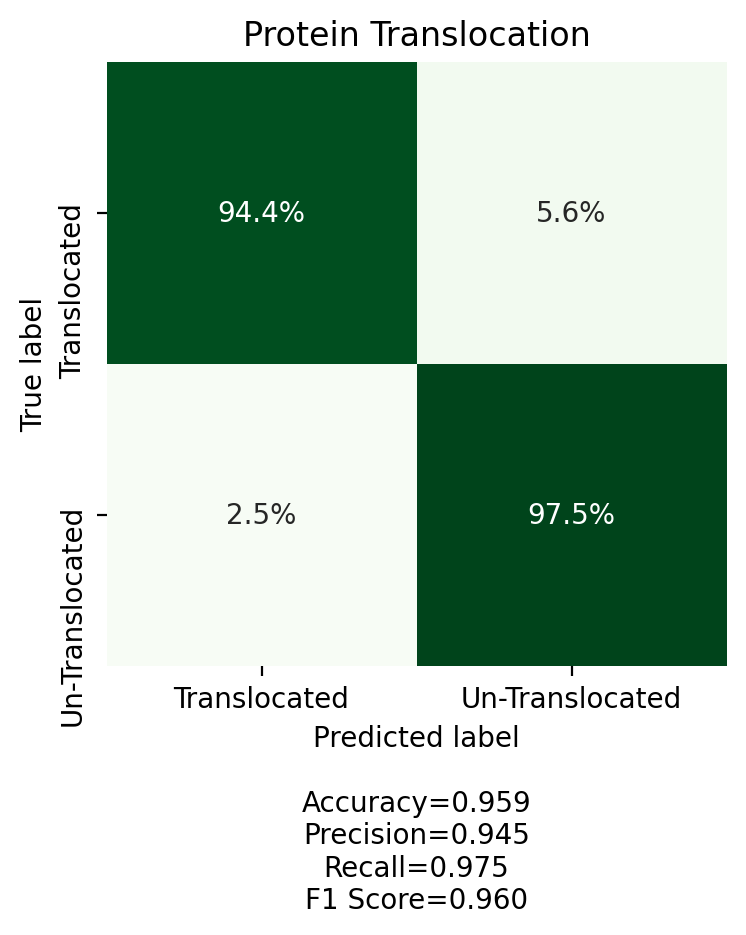

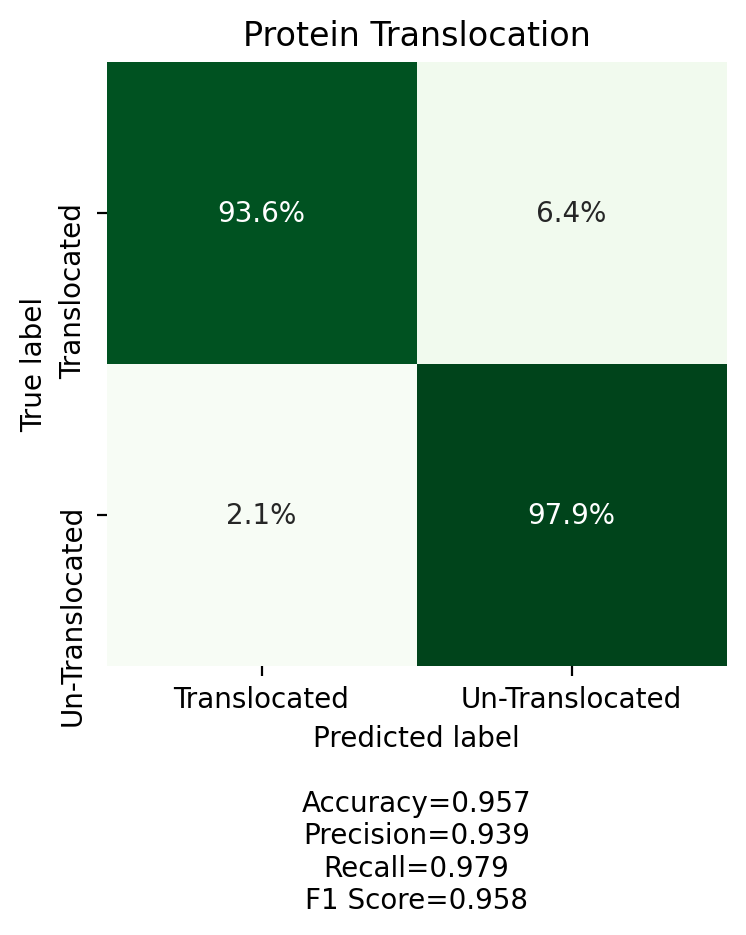

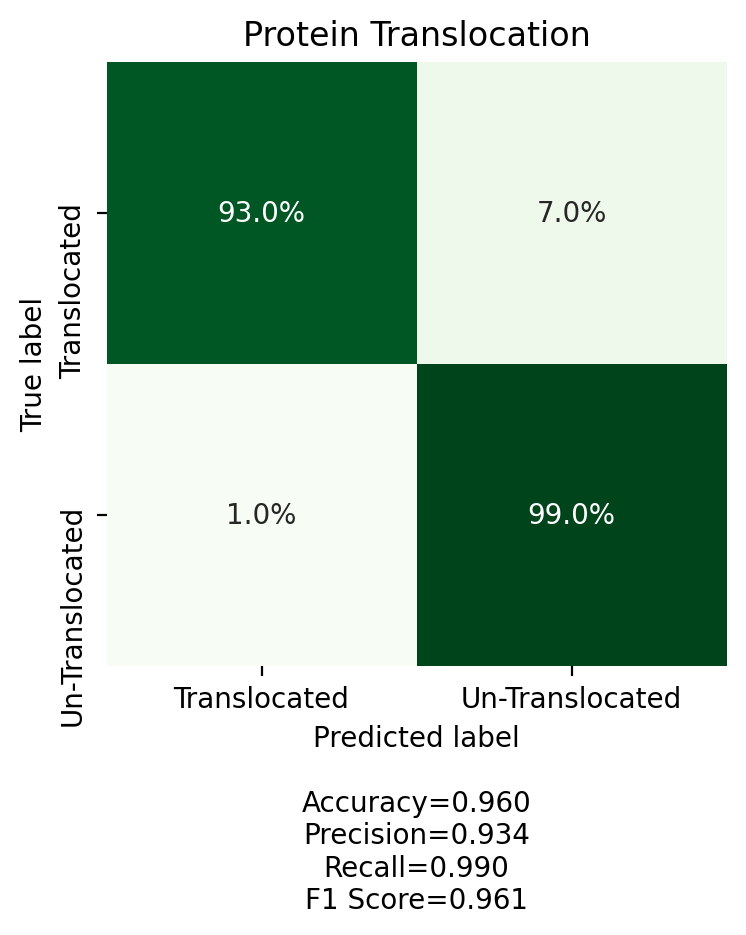

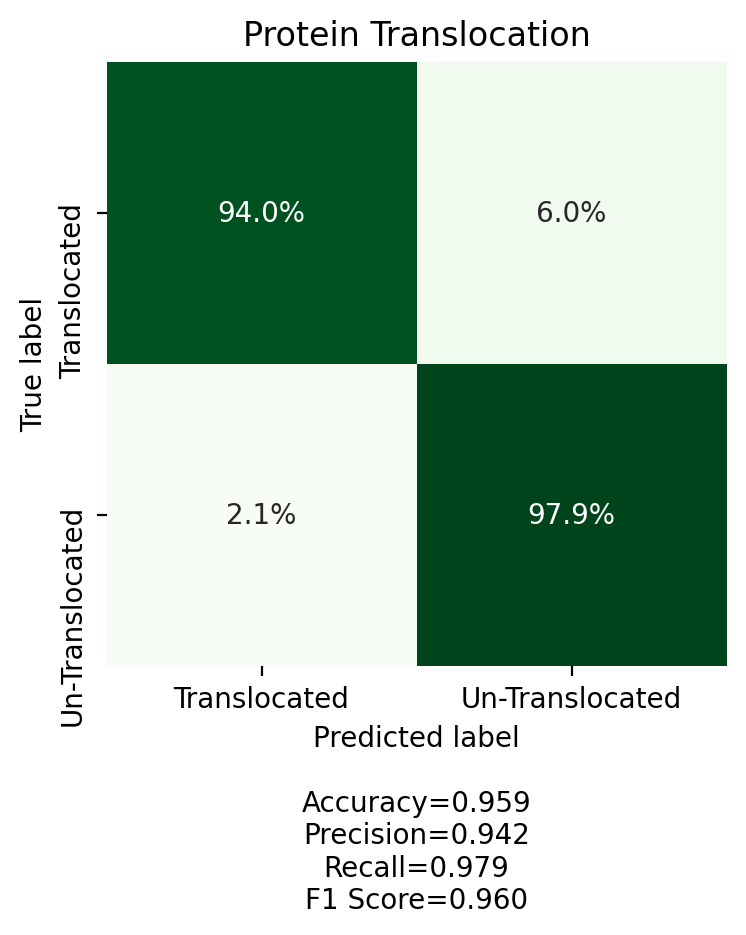

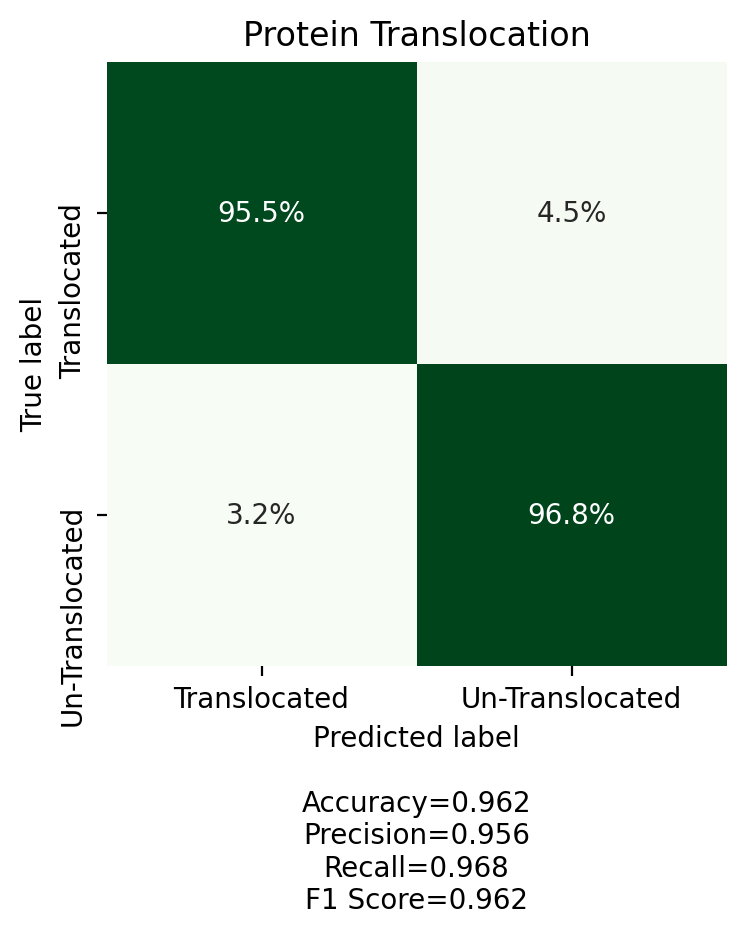

In [8]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# csv_path = './reports/PT_GroundTruthLabel&ClusterLabel.csv'
csv_path = './reports/PT_mask.csv'
csv_data = pd.read_csv(csv_path)

# sscpath = csv_data.name
tmpath = csv_data.maskname
cluster_label = csv_data.cluster

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    
transforms_tm = transforms.Resize([400, 400])

report_summary = {}
for runs, (train_index, test_index) in enumerate(skf.split(tmpath, cluster_label)):
    print("\nFold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    
    trainpath, testpath, train_label, test_label = [], [], [], []
    for i in train_index:
        trainpath.append(tmpath[i])
        train_label.append(cluster_label[i])
    for i in test_index:
        testpath.append(tmpath[i])
        test_label.append(cluster_label[i])
    print('\nTest_Index: ', test_index)

    train_datasets = MyDataset_mat(trainpath, train_label, transforms_tm=transforms_tm)
    val_datasets = MyDataset_mat(testpath, test_label, transforms_tm=transforms_tm)

    print('\nTraining data size: ', len(train_datasets))
    print('Validation data size: ', len(val_datasets))

    print('\nDataloader Initialization Start:')
    # Number of classes in the dataset
    num_classes = num_clusters

    # Batch size for training (change depending on how much memory you have)
    batch_size = 16

    # dataloaders
    dataloader_train = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=0)
    dataloader_val = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=True, num_workers=0)

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('Dataloader Initialized!')

    # Evaluate the proper model
    img_size = [400,400,1]
    to_eval = model_name + "(img_size, latent_channels=latent_channels)"
    model = eval(to_eval)
    
    model = model.to(device)
    fold = runs+1
    basedir = 'nets/ckpt_CAE_classify_00'+str(fold)+'/'
    scratch_model = torch.load(basedir+'Classify_Trained_00'+str(fold)+'_latest.pth.tar')
    model.load_state_dict(scratch_model['best_model_wts'])
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloader_val):
            inputs, label = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            if i == 0:
                print('\nLabel:', label.shape)
                labellist = label
                outputlist = outputs.cpu().clone().numpy()
                predlist = preds.cpu().clone().numpy()
            else:
                outputlist = np.append(outputlist, outputs.cpu().clone().numpy(), axis=0)
                labellist = np.append(labellist, label, axis=0)
                predlist = np.append(predlist, preds.cpu().clone().numpy(), axis=0)

    print('Label shape:', labellist.shape)
    print('Output shape:', outputlist.shape)
    print('Prediction shape:', predlist.shape)
    
    cm = confusion_matrix(labellist, predlist, labels = [0,1])
    cr = classification_report(labellist, predlist, labels = [0,1])
    bas = balanced_accuracy_score(labellist, predlist)
#     y_pred = np.transpose([pred[:, 1] for pred in outputlist])
    fpr, tpr, thresholds = metrics.roc_curve(labellist, outputlist[:,1], pos_label=1)
    auc_score = metrics.auc(fpr, tpr)
    f1_macro = metrics.f1_score(labellist, predlist, average='macro')
    f1_micro = metrics.f1_score(labellist, predlist, average='micro')
    f1_weighted = metrics.f1_score(labellist, predlist, average='weighted')
    precision_macro = metrics.precision_score(labellist, predlist, average='macro')
    precision_micro = metrics.precision_score(labellist, predlist, average='micro')
    precision_weighted = metrics.precision_score(labellist, predlist, average='weighted')
    recall_macro = metrics.recall_score(labellist, predlist, average='macro')
    recall_micro = metrics.recall_score(labellist, predlist, average='micro')
    recall_weighted = metrics.recall_score(labellist, predlist, average='weighted')
    
    report_summary['cm_'+str(fold)] = cm
    report_summary['cr_'+str(fold)] = cr
    report_summary['bas_'+str(fold)] = bas
    report_summary['auc_'+str(fold)] = auc_score
    report_summary['f1_macro_'+str(fold)] = f1_macro
    report_summary['f1_micro_'+str(fold)] = f1_micro
    report_summary['f1_weighted_'+str(fold)] = f1_weighted
    report_summary['precision_macro_'+str(fold)] = precision_macro
    report_summary['precision_micro_'+str(fold)] = precision_micro
    report_summary['precision_weighted_'+str(fold)] = precision_weighted
    report_summary['recall_macro_'+str(fold)] = recall_macro
    report_summary['recall_micro_'+str(fold)] = recall_micro
    report_summary['recall_weighted_'+str(fold)] = recall_weighted
    print('Confusion Matrix:', cm)
    print('Classification Report:', cr)
    print('Balanced Accuracy Score:', bas)
    print('AUC:', auc_score)
    print('F1 macro:', f1_macro)
    print('F1 micro:', f1_micro)
    print('F1 weighted:', f1_weighted)
    print('Precision macro:', precision_macro)
    print('Precision micro:', precision_micro)
    print('Precision weighted:', precision_weighted)
    print('Recall macro:', recall_macro)
    print('Recall micro:', recall_micro)
    print('Recall weighted:', recall_weighted)

    confusionMat = np.asarray(cm)
    sumconfusion = np.sum(confusionMat,axis = 1).T
    summat = np.tile(sumconfusion,(2,1)).T
    percentconfusion_val = np.divide(confusionMat,summat)

    categories = ['Translocated','Un-Translocated']
    make_confusion_matrix(percentconfusion_val, 
                          #group_names=labels,
                          categories=categories,
                          percent=False,
                          cbar=False,
                          figsize=(4 ,4),
                          cmap='Greens',my_dpi=200,title = 'Protein Translocation',
                          saved=True, save_name=basedir+'Confusion Martrix Unsupervised Learning - PT.jpg')


In [12]:
import csv
# open file for writing, "w" is writing
w = csv.writer(open("report_summary.csv", "w"))

# loop over dictionary keys and values
for key, val in report_summary.items():

    # write every key and value to file
    w.writerow([key, val])
w.close()

In [8]:
fold = 5
basedir = 'nets/ckpt_CAE_classify_00'+str(fold)+'/'
scratch_model = torch.load(basedir+'Classify_Trained_00'+str(fold)+'_latest.pth.tar')
print(scratch_model.keys())

dict_keys(['epoch', 'state_dict', 'best_model_wts', 'losses_tr', 'losses_val', 'accuracy_train', 'accuracy_val', 'learning_rate'])


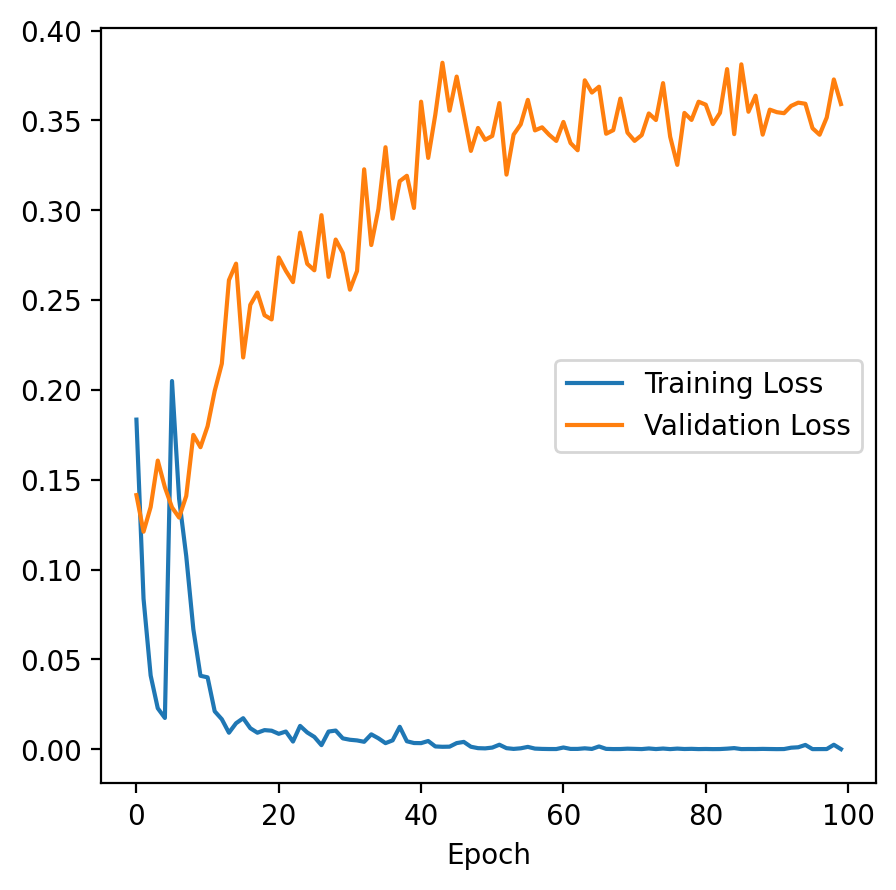

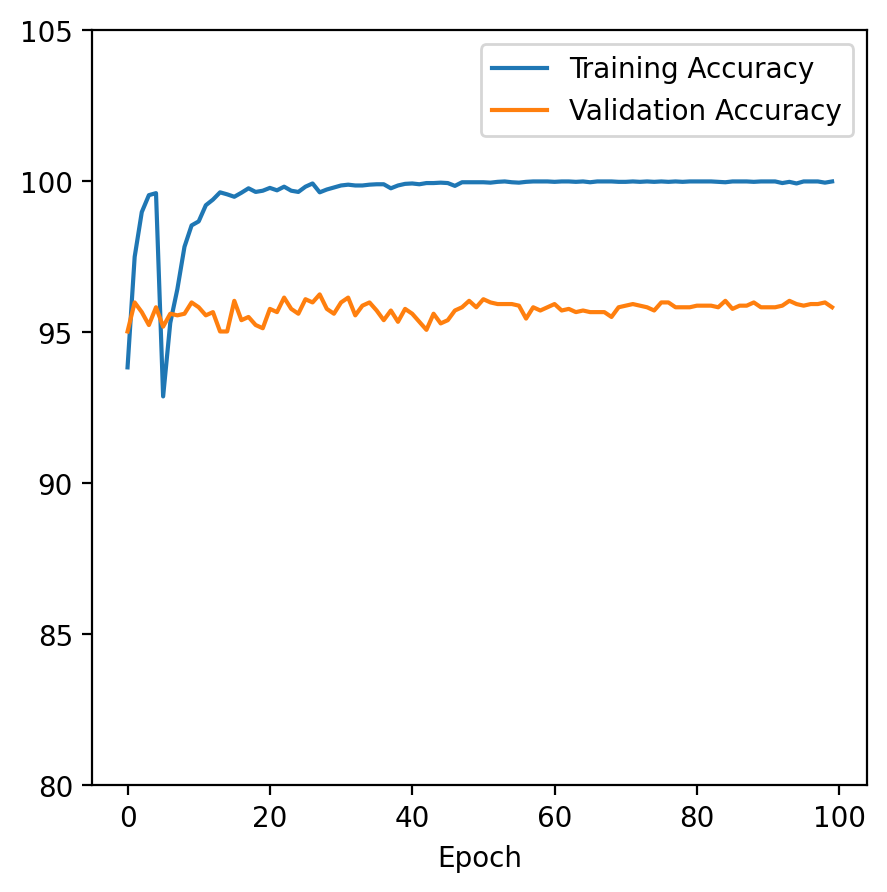

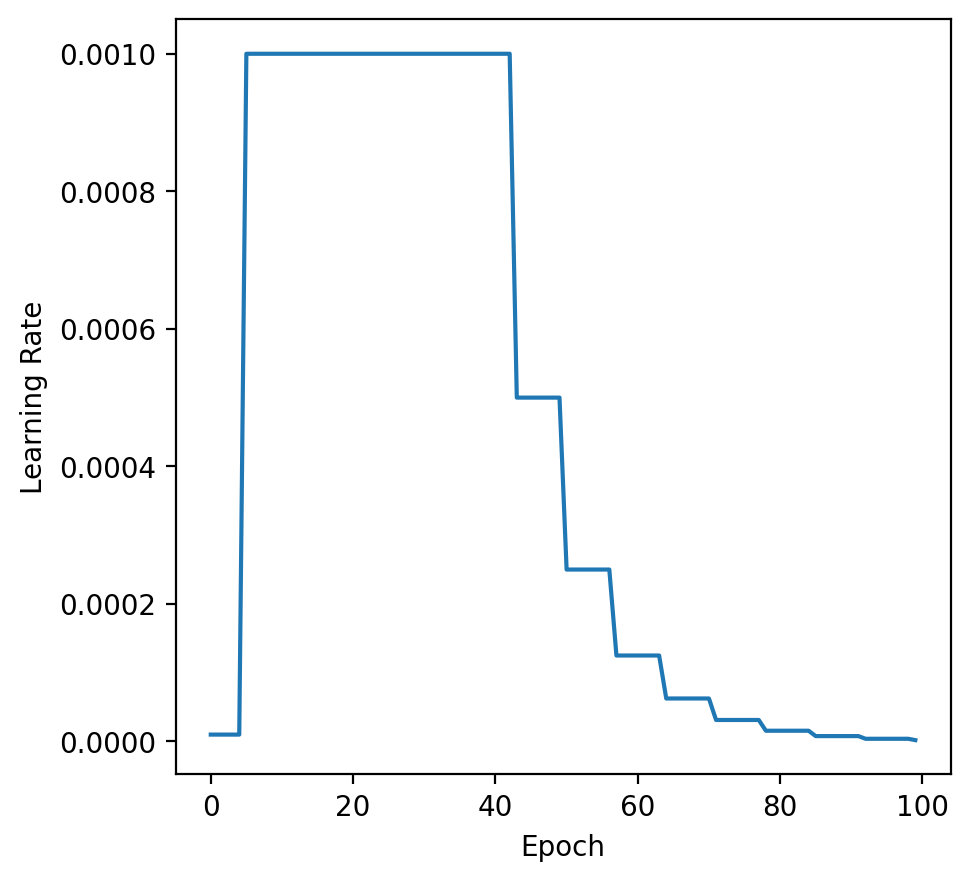

In [9]:
from matplotlib import pyplot as plt
my_dpi = 200
plt.figure(figsize=(5, 5), dpi=my_dpi)
plt.plot(range(0,scratch_model['epoch']), scratch_model['losses_tr'],label='Training Loss')
plt.plot(range(0,scratch_model['epoch']), scratch_model['losses_val'],label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
# plt.savefig(basedir + 'Fig_save/Unsupervised learning - Loss.png', dpi=200 * 10)
plt.show()

plt.figure(figsize=(5, 5), dpi=my_dpi)
plt.plot(range(0,scratch_model['epoch']), scratch_model['accuracy_train'],label='Training Accuracy')
plt.plot(range(0,scratch_model['epoch']), scratch_model['accuracy_val'],label='Validation Accuracy')
plt.ylim((80,105))
plt.legend()
plt.xlabel('Epoch')
# plt.savefig(basedir + 'Fig_save/Unsupervised learning - Accuracy.png', dpi=200 * 10)
plt.show()


plt.figure(figsize=(5, 5), dpi=my_dpi)
plt.plot(range(0,scratch_model['epoch']), scratch_model['learning_rate'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
# plt.savefig(basedir + 'Fig_save/Unsupervised learning - LR.png', dpi=200 * 10)
plt.show()